# Connecting the Drive to the Notebook


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download the Scopus.csv file and put it in MyDrive folder of your Google Drive


# Loading The CSV file


In [ ]:
import pandas as pd
import requests
csv = pd.read_csv('/content/drive/MyDrive/scopus.csv')
df = pd.DataFrame(csv)
dois =df['DOI'].astype(str)

# Downloading the XMLs from Scopus using SCOPUS API

In [ ]:
import os
status_code = []
j =1
os.makedirs('/content/drive/MyDrive/xmls',exist_ok = True)
for i, doi in enumerate(dois):
  xml_url='https://api.elsevier.com/content/article/doi/' + doi + '?view=FULL'

  headers = {
            'X-ELS-APIKEY': 'c8cf76a7333ef42cbb26d1ce3aadc8bd',
            'Accept': 'text/xml'
          }

  r = requests.get(xml_url,stream = True,  headers=headers, timeout=30)

  status_code.append(r.status_code)
  if r.status_code == 200:
    try:
      writefile  = open("/content/drive/MyDrive/xmls/" + str(j) + ".xml", 'wb')



      for chunk in r.iter_content(2048):
        writefile.write((chunk))
    except:
      continue
  j = j+1

df['StatusCode'] = status_code

df.to_csv('/content/drive/MyDrive/scopus.csv',index=False)


# Obtaining Tags for Images and Captions
## Using Element Tree to search the XML file


In [ ]:

import xml.etree.ElementTree as ET
import pandas as pd
import csv
import re
os.makedirs('/content/drive/MyDrive/csvs',exist_ok=True)
for i, row in df.iterrows():
    status_code = row['StatusCode']
    if status_code == 200:
        print(i+1)
        xml_file = f'/content/drive/MyDrive/xmls/{i + 1}.xml'

        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            images = []
            captions = []
            # Extracting tags for captions
            for figure in root.findall('.//ce:figure', namespaces={'ce': 'http://www.elsevier.com/xml/common/dtd'}):
                link_element = figure.find('.//ce:link', namespaces={'ce': 'http://www.elsevier.com/xml/common/dtd'})
                locator = link_element.attrib.get('locator') if link_element is not None else None

                caption_element = figure.find('.//ce:caption', namespaces={'ce': 'http://www.elsevier.com/xml/common/dtd'})
                if caption_element is not None:
                    simple_para_element = caption_element.find('.//ce:simple-para', namespaces={'ce': 'http://www.elsevier.com/xml/common/dtd'})
                    if simple_para_element is not None:
                        raw_caption = ET.tostring(simple_para_element, encoding='unicode', method='text')
                        caption = re.sub('<.*?>', '', raw_caption)
                        caption = " ".join(caption.split())
                    else:
                        caption = None
                    captions.append(caption)
                else:
                    captions.append(None)
            # Extracting tags for Image
            for attachment in root.findall('.//xocs:attachment', namespaces={'xocs': 'http://www.elsevier.com/xml/xocs/dtd'}):
                attachment_eid = attachment.find('.//xocs:attachment-eid', namespaces={'xocs': 'http://www.elsevier.com/xml/xocs/dtd'}).text
                ucs_locator = attachment.find('.//xocs:ucs-locator', namespaces={'xocs': 'http://www.elsevier.com/xml/xocs/dtd'}).text
                filename = attachment.find('.//xocs:filename', namespaces={'xocs': 'http://www.elsevier.com/xml/xocs/dtd'}).text
                images.append((attachment_eid, ucs_locator, filename))

            # Adding to the csv file
            with open(f'/content/drive/MyDrive/csvs/output{i + 1}.csv', 'w', newline='', encoding='utf-8') as csvfile:
                csv_writer = csv.writer(csvfile)
                csv_writer.writerow(['UTD EID', 'UCS Locator', 'Filename', 'Caption'])
                for image, caption in zip(images, captions):
                    csv_writer.writerow([image[0], image[1], image[2], caption])

            df_output = pd.read_csv(f'/content/drive/MyDrive/csvs/output{i + 1}.csv')
            df_output['link'] = df_output['UTD EID'].apply(lambda x: f'https://ars.els-cdn.com/content/image/{x}'.replace('.jpg', '_lrg.jpg'))
            df_output.to_csv(f'/content/drive/MyDrive/csvs/output{i + 1}.csv', index=False)

        except ET.ParseError as e:
            print(f"ParseError: {e}. The file {xml_file} might be incomplete or malformed.")
        except Exception as e:
            print(f"An error occurred while processing the file {xml_file}: {e}")


7
12
13
16
25
26
28
29
30
45
46
53
55
68
80
85
86
95
96
99
ParseError: no element found: line 12311, column 37. The file /content/drive/MyDrive/xmls/99.xml might be incomplete or malformed.


In [ ]:
import os
import re
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/scopus.csv')

# Keywords to be highlighted
keywords = [
    'strain', 'DSC', 'stress', 'heat flow', 'displacement', 'force',
    'martensite', 'fraction', 'load', 'X-Ray', 'temp', 'Differential',
    'scanning', 'calorimetry', 'curve'
]

# Function to highlight keywords in the caption
def highlight_keywords(caption, keywords):
    if not isinstance(caption, str):
        caption = ''

    found = False
    found_keywords = []
    for keyword in keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', caption, re.IGNORECASE):
            found = True
            found_keywords.append(keyword)
    return found, found_keywords


for i, row in df.iterrows():
    status_code = row['StatusCode']


    if status_code == 200:
        output_file = f'/content/drive/MyDrive/csvs/output{i+1}.csv'

        # Check if the file exists
        if os.path.exists(output_file):
            try:
                # Read the corresponding output CSV file
                dof = pd.read_csv(output_file)

                # Apply the keyword highlighting function
                results = dof['Caption'].apply(lambda x: highlight_keywords(x, keywords))
                dof['contains_keywords'] = results.apply(lambda x: 1 if x[0] else 0)
                dof['found_keywords'] = results.apply(lambda x: ', '.join(x[1]) if x[1] else '')

                # Save the updated DataFrame back to the CSV file
                dof.to_csv(output_file, index=False)

            except Exception as e:
                print(f"An error occurred while processing the file {output_file}: {e}")
        else:
            print(f"The file {output_file} does not exist.")


The file /content/drive/MyDrive/csvs/output99.csv does not exist.


# Downloading the images from the csv


In [ ]:
import os
import pandas as pd
import requests
import shutil

df = pd.read_csv('/content/drive/MyDrive/scopus.csv')


for i, row in df.iterrows():
    status_code = row['StatusCode']
    mloc = f'/content/drive/MyDrive/images/Master'
    os.makedirs(mloc,exist_ok=True)

    if status_code == 200:
        output_file = f'/content/drive/MyDrive/csvs/output{i+1}.csv'

        # Check if the corresponding output CSV file exists
        if os.path.exists(output_file):
            dof = pd.read_csv(output_file)

            # Filter the DataFrame to get rows where 'contains_keywords' is 1
            contain = dof[dof['contains_keywords'] == 1]

            # Check if there are any rows to process
            if not contain.empty:
                # Define the directory to save the images
                loc = f'/content/drive/MyDrive/images/{i+1}'
                os.makedirs(loc, exist_ok=True)

                # Variable to track if any file was downloaded
                files_downloaded = False

                # Loop through the filtered rows
                for i1, r2 in contain.iterrows():
                    url = r2['link']

                    try:
                        response = requests.get(url, stream=True, timeout=30)

                        # Check if the request was successful
                        if response.status_code == 200:
                            # Extract the file name from the URL
                            file_name = url.split("/")[-1]

                            # Define the complete path for saving the file
                            save_path = os.path.join(loc, file_name)
                            mloc2 = os.path.join(mloc,file_name)

                            # Write the file data to a file
                            with open(save_path, 'wb') as file:
                                for chunk in response.iter_content(1024):
                                    file.write(chunk)
                            shutil.copy2(save_path,mloc2)
                            print(f"File downloaded: {save_path}")
                            files_downloaded = True
                        else:
                            print(f"Failed to download file: {url} (Status code: {response.status_code})")
                    except Exception as e:
                        print(f"Error downloading file: {url} ({e})")

                # If no files were downloaded, remove the created directory
                if not files_downloaded:
                    os.rmdir(loc)
                    print(f"Removed empty directory: {loc}")
        else:
            print(f"Output file not found: {output_file}")


File downloaded: /content/drive/MyDrive/images/7/1-s2.0-S0141029624009295-gr1_lrg.jpg
File downloaded: /content/drive/MyDrive/images/7/1-s2.0-S0141029624009295-gr22_lrg.jpg
File downloaded: /content/drive/MyDrive/images/7/1-s2.0-S0141029624009295-gr23_lrg.jpg
File downloaded: /content/drive/MyDrive/images/7/1-s2.0-S0141029624009295-gr17_lrg.jpg
File downloaded: /content/drive/MyDrive/images/7/1-s2.0-S0141029624009295-gr18_lrg.jpg
File downloaded: /content/drive/MyDrive/images/7/1-s2.0-S0141029624009295-gr19_lrg.jpg
File downloaded: /content/drive/MyDrive/images/7/1-s2.0-S0141029624009295-gr13_lrg.jpg
File downloaded: /content/drive/MyDrive/images/7/1-s2.0-S0141029624009295-gr14_lrg.jpg
File downloaded: /content/drive/MyDrive/images/7/1-s2.0-S0141029624009295-gr16_lrg.jpg
File downloaded: /content/drive/MyDrive/images/7/1-s2.0-S0141029624009295-gr11_lrg.jpg
File downloaded: /content/drive/MyDrive/images/13/1-s2.0-S1751616124002856-gr7_lrg.jpg
File downloaded: /content/drive/MyDrive/imag

# Installing required libraries


In [ ]:
!pip install pytesseract
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y libtesseract-dev


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Ign:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,152 kB]
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [2,841 kB]
Hit:11 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:13 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:14 htt

In [ ]:
!tesseract --version


tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [ ]:
import re
import pandas as pd
from PIL import Image, ImageEnhance
import pytesseract
import os



def highlight_keywords(caption, keywords):
    """Function to highlight keywords in a given caption."""
    if not isinstance(caption, str):
        caption = ''

    found = False
    for keyword in keywords:
        if re.search(r'\b' + re.escape(keyword) + r'\b', caption, re.IGNORECASE):
            found = True
            caption = re.sub(r'(?i)\b' + re.escape(keyword) + r'\b', r'**\g<0>**', caption)
    return found, caption

def process_image(img_path, keywords):
    """Function to process an image, extract text, and highlight keywords."""
    try:
        image = Image.open(img_path)
        image = image.convert('L')  # Convert image to grayscale
        enhancer = ImageEnhance.Contrast(image)
        image = enhancer.enhance(2)  # Enhance image contrast
        text = pytesseract.image_to_string(image)  # Extract text from image
        found, highlighted_text = highlight_keywords(text, keywords)  # Highlight keywords in extracted text
        return 2 if found else 0, text  # Return status (2 if keywords found, otherwise 0) and extracted text
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return 1, ""  # Return status 1 (error) and empty text on exception

def process_row(row, img_path, keywords):
    """Function to process a row of data."""
    if row['contains_keywords'] == 1:
        contains_keywords2, text = process_image(img_path, keywords)  # Process image and get results
        row['contains_keywords2'] = contains_keywords2  # Store result in 'contains_keywords2' column
        row['text'] = text  # Store extracted text in 'text' column
    return row  # Return processed row

def main():
    """Main function to execute processing on CSV files."""
    df = pd.read_csv('/content/drive/MyDrive/scopus.csv')

    for i, row in df.iterrows():
        if row['StatusCode'] == 200:  # Check if StatusCode is 200(file is present)
            try:
                # Read corresponding output CSV file
                dof = pd.read_csv(f'/content/drive/MyDrive/csvs/output{i+1}.csv')
                print(f"Processing output{i+1}.csv")

                img_dir = f"/content/drive/MyDrive/images/{i+1}/"  # Directory path for images
                # Apply processing to each row of the output CSV file
                dof = dof.apply(
                    lambda dof_row: process_row(dof_row, os.path.join(img_dir, dof_row['UTD EID'][:-4] + '_lrg.jpg'), keywords),
                    axis=1
                )

                dof.to_csv(f'/content/drive/MyDrive/csvs/output{i+1}.csv', index=False)  # Save processed data back to output CSV file
                print(f"Saved processed data to output{i+1}.csv")

            except FileNotFoundError as fnf_error:
                print(f"Error: {fnf_error}. Skipping processing of output{i+1}.csv")

            except Exception as e:
                print(f"Unexpected error processing output{i+1}.csv: {e}")

    df.to_csv('/content/drive/MyDrive/scopus.csv', index=False)  # Save updated main DataFrame back to scopus2.csv
    print("Main data frame updated and saved.")

if __name__ == "__main__":
    # Keywords to consider for highlighting
    keywords = [
        'strain', 'DSC', 'stress', 'heat flow', 'displacement', 'force',
        'martensite', 'fraction', 'load', 'X-Ray', 'temp', 'Differential',
        'scanning', 'calorimetry', 'curve'
    ]
    main()  # Execute main function if script is run directly


Processing output7.csv
Saved processed data to output7.csv
Processing output12.csv
Saved processed data to output12.csv
Processing output13.csv
Saved processed data to output13.csv
Processing output16.csv
Saved processed data to output16.csv
Processing output25.csv
Saved processed data to output25.csv
Processing output26.csv
Saved processed data to output26.csv
Processing output28.csv
Saved processed data to output28.csv
Processing output29.csv
Saved processed data to output29.csv
Processing output30.csv
Saved processed data to output30.csv
Processing output45.csv
Saved processed data to output45.csv
Processing output46.csv
Saved processed data to output46.csv
Processing output53.csv
Saved processed data to output53.csv
Processing output55.csv
Saved processed data to output55.csv
Processing output68.csv
Saved processed data to output68.csv
Processing output80.csv
Saved processed data to output80.csv
Processing output85.csv
Saved processed data to output85.csv
Processing output86.csv
Sa

# Creating Individual Files for each paper with Relevant Images , CSV file ,

*   List item
*   List item

XMLS file and the Link of the Paper


In [ ]:
import pandas as pd
import os
import shutil

# Function to process the images and CSV files
def main():
    df = pd.read_csv('/content/drive/MyDrive/scopus.csv')
    count = 0

    for i, row in df.iterrows():
        df.at[i, 'Processed'] = 0
        if row['StatusCode'] == 200:
            try:
                dof = pd.read_csv(f'/content/drive/MyDrive/csvs/output{i+1}.csv')
                print(f"Processing output{i+1}.csv")

                img_dir = f"/content/drive/MyDrive/images/{i+1}/"
                refined_img_dir = f"/content/drive/MyDrive/images/Refined images/{i+1}/"

                # Check if there are rows in dof that meet the condition
                if len(dof) > 0 and any(dof['contains_keywords2'] == 2):
                    os.makedirs(refined_img_dir, exist_ok=True)

                    copied = False
                    for index, r1 in dof.iterrows():
                        try:
                            if r1['contains_keywords2'] == 2:
                                count += 1
                                src_img = os.path.join(img_dir, r1['UTD EID'][:-4] + '_lrg.jpg')
                                dst_img = os.path.join(refined_img_dir, r1['UTD EID'][:-4] + '_lrg.jpg')
                                shutil.copy(src_img, dst_img)
                                copied = True
                        except Exception as e:
                            print(f"Error processing row {index}: {e}")

                    # Check if any image was copied
                    if copied:
                        firstloc = f"/content/drive/MyDrive/xmls/{i+1}.xml"
                        secondloc = f"/content/drive/MyDrive/csvs/output{i+1}.csv"
                        shutil.copy(firstloc, refined_img_dir)
                        shutil.copy(secondloc, refined_img_dir)

                        # Update scopus.csv to mark this row as processed
                        df.at[i, 'Processed'] = 1

                        # Save the link to a text file in the refined image directory
                        link = row['Link']
                        link_file_path = os.path.join(refined_img_dir, f"Link_{i+1}.txt")
                        with open(link_file_path, 'w') as link_file:
                            link_file.write(link)
                            print(f"Link saved to {link_file_path}")

                dof.to_csv(f'/content/drive/MyDrive/csvs/output{i+1}.csv', index=False)

            except FileNotFoundError:
                print(f"FileNotFoundError: output{i+1}.csv not found.")
            except Exception as ex:
                print(f"Error processing output{i+1}.csv: {ex}")

    print(f"Total images copied: {count}")

    # Save the updated scopus.csv with the 'Processed' column
    df.to_csv('/content/drive/MyDrive/scopus.csv', index=False)

if __name__ == "__main__":
    main()


Processing output7.csv
Link saved to /content/drive/MyDrive/images/Refined images/7/Link_7.txt
Processing output12.csv
Error processing output12.csv: 'contains_keywords2'
Processing output13.csv
Link saved to /content/drive/MyDrive/images/Refined images/13/Link_13.txt
Processing output16.csv
Link saved to /content/drive/MyDrive/images/Refined images/16/Link_16.txt
Processing output25.csv
Link saved to /content/drive/MyDrive/images/Refined images/25/Link_25.txt
Processing output26.csv
Processing output28.csv
Link saved to /content/drive/MyDrive/images/Refined images/28/Link_28.txt
Processing output29.csv
Link saved to /content/drive/MyDrive/images/Refined images/29/Link_29.txt
Processing output30.csv
Link saved to /content/drive/MyDrive/images/Refined images/30/Link_30.txt
Processing output45.csv
Link saved to /content/drive/MyDrive/images/Refined images/45/Link_45.txt
Processing output46.csv
Link saved to /content/drive/MyDrive/images/Refined images/46/Link_46.txt
Processing output53.c

In [15]:
!pip install ultralytics

In [16]:
%cd /content/drive/MyDrive
!git clone https://github.com/PrathameshLadhe/sma_train

/content/drive/MyDrive
fatal: destination path 'sma_train' already exists and is not an empty directory.


In [18]:
## Running a model on images with pre-trained weights to detect plots , their x-label and y-label
!yolo task=detect mode=predict model='/content/drive/MyDrive/sma_train/train/weights/best.pt' conf=0.25 source='/content/drive/MyDrive/images/Master'

Ultralytics YOLOv8.2.76 🚀 Python-3.10.12 torch-2.3.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 3,006,233 parameters, 0 gradients, 8.1 GFLOPs

image 1/134 /content/drive/MyDrive/images/Master/1-s2.0-S0020740324006106-gr10_lrg.jpg: 480x640 2 graphs, 7 xlabels, 168.6ms
image 2/134 /content/drive/MyDrive/images/Master/1-s2.0-S0020740324006106-gr11_lrg.jpg: 480x640 2 graphs, 3 xlabels, 168.6ms
image 3/134 /content/drive/MyDrive/images/Master/1-s2.0-S0020740324006106-gr12_lrg.jpg: 352x640 2 graphs, 3 xlabels, 2 ylabels, 121.5ms
image 4/134 /content/drive/MyDrive/images/Master/1-s2.0-S0020740324006106-gr13_lrg.jpg: 224x640 1 graph, 2 xlabels, 1 ylabel, 91.9ms
image 5/134 /content/drive/MyDrive/images/Master/1-s2.0-S0020740324006106-gr1_lrg.jpg: 352x640 1 graph, 1 xlabel, 2 ylabels, 113.0ms
image 6/134 /content/drive/MyDrive/images/Master/1-s2.0-S0020740324006106-gr2_lrg.jpg: 352x640 2 graphs, 2 xlabels, 2 ylabels, 110.6ms
image 7/134 /content/drive/MyDrive/images/Maste

# Saving all the images in the Drive


In [21]:
import shutil
import os
from datetime import datetime
# Define source and destination paths
src_dir = '/content/drive/MyDrive/runs'
base_dst_dir = '/content/drive/MyDrive/Archived_Runs'

# Create a timestamped folder name to avoid overwriting
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
dst_dir = os.path.join(base_dst_dir, f'runs_{timestamp}')

# Ensure the base destination directory exists
os.makedirs(base_dst_dir, exist_ok=True)

# Copy the entire directory
try:
    shutil.copytree(src_dir, dst_dir)
    print(f"Folder copied from {src_dir} to {dst_dir}")
    shutil.rmtree('/content/drive/MyDrive/runs')
    print('File deleted.')
except Exception as e:
    print(f"Error copying folder: {e}")


Folder copied from /content/drive/MyDrive/runs to /content/drive/MyDrive/Archived_Runs/runs_20240812_131643
File deleted.


# Getting the YOLO Predictions in YOLO txt format for further use.

In [22]:
from ultralytics import YOLO
import os

# Load the model
model = YOLO('/content/drive/MyDrive/sma_train/train/weights/best.pt')

# Create output directory if it doesn't exist
output_dir = '/content/drive/MyDrive/images/Master/output'  # Keep this for saving results
os.makedirs(output_dir, exist_ok=True)

# Iterate over images in the CORRECT directory
image_dir = '/content/drive/MyDrive/images/Master'  # This is where the images should be
for image_file in os.listdir(image_dir):
    if image_file.endswith(('.jpg', '.png', '.jpeg')):  # Filter for image files
        # Full path to the image
        image_path = os.path.join(image_dir, image_file)

        # Get predictions for the image
        predictions = model(image_path, save_txt=None)

        # Prepare output file path
        base_name = os.path.splitext(image_file)[0]
        output_file_path = os.path.join(output_dir, f"{base_name}.txt")

        # Write predictions to the text file
        with open(output_file_path, 'w') as file:
            for idx, box in enumerate(predictions[0].boxes.xywhn):  # Iterate over each detected box
                cls = int(predictions[0].boxes.cls[idx].item())
                # Write line to file in YOLO label format: cls x_center y_center width height
                file.write(f"{cls} {box[0].item()} {box[1].item()} {box[2].item()} {box[3].item()}\n")


image 1/1 /content/drive/MyDrive/images/Master/1-s2.0-S0141029624009295-gr1_lrg.jpg: 640x448 (no detections), 168.9ms
Speed: 4.7ms preprocess, 168.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /content/drive/MyDrive/images/Master/1-s2.0-S0141029624009295-gr22_lrg.jpg: 416x640 1 graph, 207.4ms
Speed: 5.4ms preprocess, 207.4ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/drive/MyDrive/images/Master/1-s2.0-S0141029624009295-gr23_lrg.jpg: 544x640 1 graph, 1 xlabel, 1 ylabel, 183.4ms
Speed: 3.6ms preprocess, 183.4ms inference, 0.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/images/Master/1-s2.0-S0141029624009295-gr17_lrg.jpg: 544x640 1 graph, 1 xlabel, 1 ylabel, 168.0ms
Speed: 4.0ms preprocess, 168.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/drive/MyDrive/images/Master/1-s2.0-S0141029624009295-gr18_lrg.jpg: 544x640 1 graph, 1 xlabel,

# Explaining the YOLO txt format


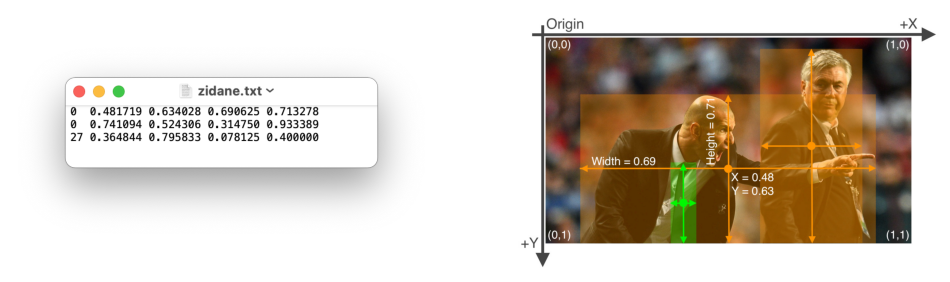

In [30]:
import matplotlib.pyplot as plt
from PIL import Image


img_path = '/content/drive/MyDrive/yolo explained/112467037-d2568c00-8d66-11eb-8796-55402ac0d62f.png'
img_path2 = '/content/drive/MyDrive/yolo explained/91506361-c7965000-e886-11ea-8291-c72b98c25eec.jpg'


img1 = Image.open(img_path)
img2 = Image.open(img_path2)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


axs[0].imshow(img1)
axs[0].axis('off')


axs[1].imshow(img2)
axs[1].axis('off')

plt.show()